In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

[Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance)

# [sklearn.model_selection.learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)
Определяет перекрестную проверку результатов обучения и тестов для разных размеров обучающей выборки.

Генератор перекрестной проверки разбивает весь набор данных k раз на обучающие и тестовые данные.
Подмножества обучающего набора с различными размерами будут использоваться для обучения оценщика, и будет вычисляться оценка для каждого размера обучающего подмножества и тестового набора. После этого баллы будут усреднены по всем k прогонам для каждого размера тренировочного подмножества.

# [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [2]:
# создаём необходимые константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
COLORS = ['#408FB0', '#50B985', '#DB565F', '#FCB06E']
customPalette = sns.set_palette(sns.color_palette(COLORS))

In [3]:
# настраиваем визуализацию
custormPalette = sns.set_palette(sns.color_palette(COLORS))
sns.set(rc={'figure.figsize': (9, 6)})

# [seaborn.set_palette](https://seaborn.pydata.org/generated/seaborn.set_palette.html)

# [seaborn.color_palette](https://seaborn.pydata.org/generated/seaborn.color_palette.html)

In [4]:
# загружаем датасет
df = pd.read_csv('E:\GitHub репозитории\Data-Science-course-by-miracl6\CSV\\insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# заменим значения yes/no на 1/0
df.smoker = df.smoker.map({'yes': 1, 'no': 0})

# [pandas.Series.map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [6]:
# проверяем есть ли пропуски в данных
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

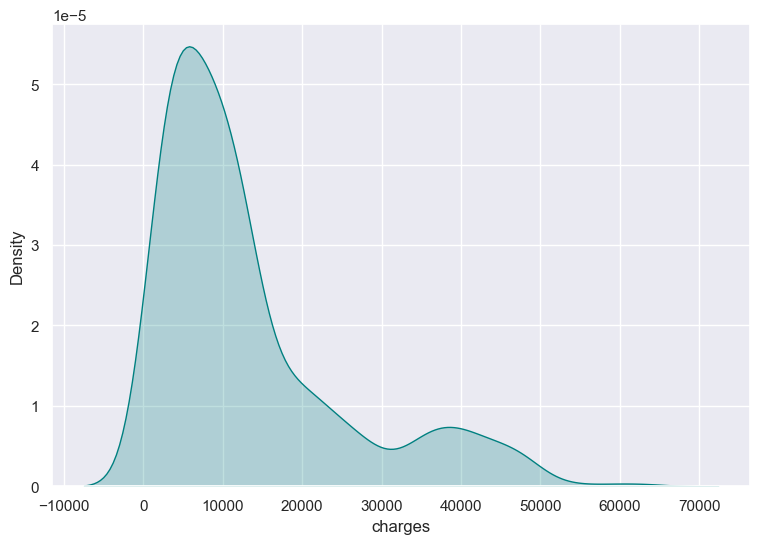

In [7]:
# рассмотрим распределение целевой переменной charges
sns.set(rc={'figure.figsize': (9, 6)})
sns.kdeplot(df.charges, fill=True, color='teal');

# [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

Отметим, что распределение ненормальное, есть длинных хвост, поэтому стоит аккуратно подходить к выбору метрики. Больше всего будем ориентироваться на MAE, так как метрику устойчива к выбросам.

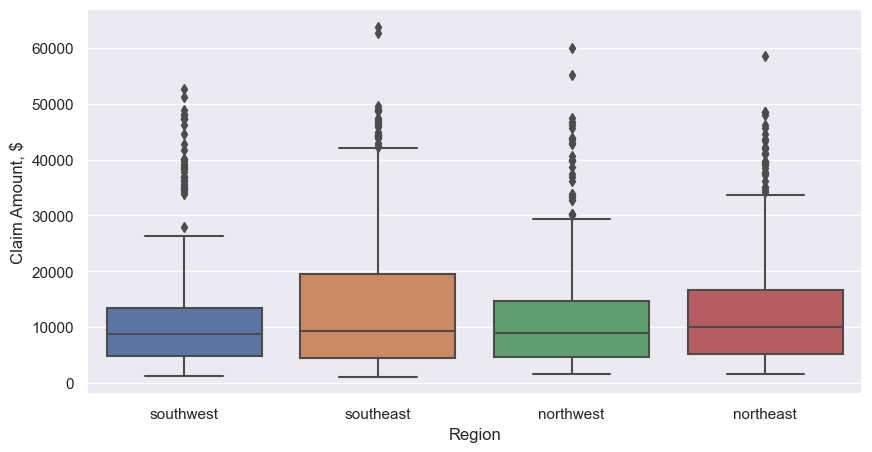

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='region', y='charges', palette=customPalette)
plt.xlabel('Region')
plt.ylabel('Claim Amount, $')
plt.show()

Для каждого региона графики показывают, что расходы, оплачиваемые медицинской страховкой, имеют немного разные значения. Charges имеет больший разброс в Юго-Восточном регионе, а также самые высокие максимальные значения. В Северо-Восточном регионе самая высокая медианная стоимость, но большой разницы между другими регионами нет.

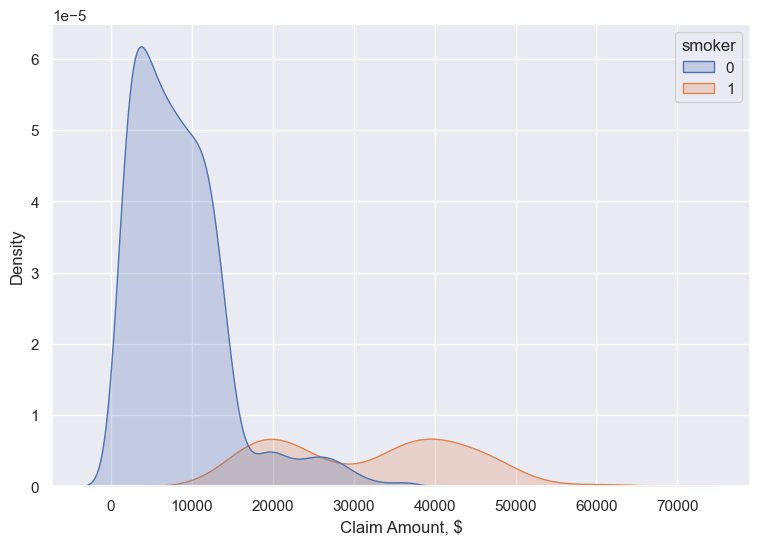

In [9]:
sns.kdeplot(data=df, hue='smoker', x='charges', fill=True)
plt.xlabel('Claim Amount, $')
plt.show()

In [10]:
df.groupby('smoker')['charges'].median()

smoker
0     7345.40530
1    34456.34845
Name: charges, dtype: float64

Медианное значение суммы charges для курильщиков составляет около 34456 долларов, что почти в 5 раз выше суммы для некурящих. 

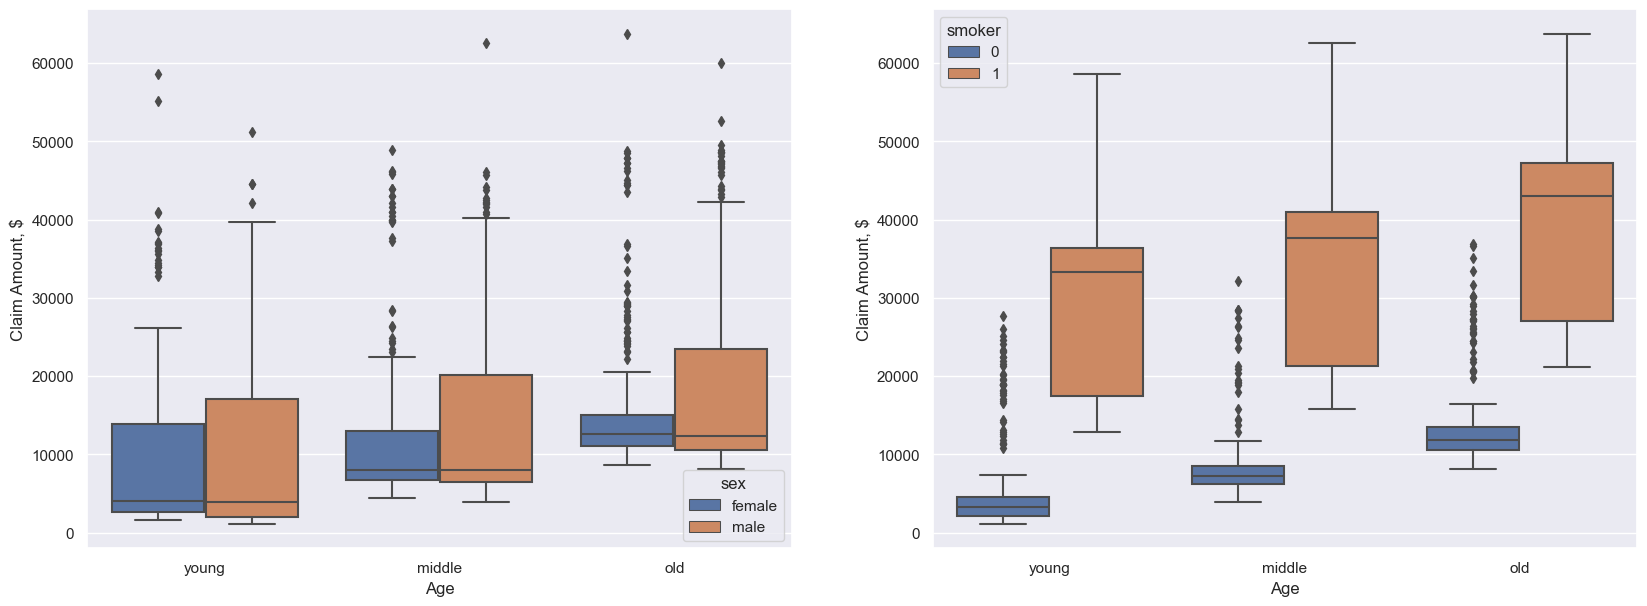

In [11]:
df_ = df.copy()
df_['age_bins'] = pd.cut(df_.age, bins=3, labels=['young', 'middle', 'old'])

fix, axes = plt.subplots(ncols=2, figsize=(20, 7))
sns.boxplot(data=df_, x='age_bins', y='charges', hue='sex', palette=customPalette, ax=axes[0])
sns.boxplot(data=df_, x='age_bins', y='charges', hue='smoker', palette=customPalette, ax=axes[1])

axes[0].set_xlabel('Age')
axes[0].set_ylabel('Claim Amount, $')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Claim Amount, $')
plt.show()

Чем выше значение возраста, тем больше расходов на страховку. Для мужчин разброс значений расходов на страховку больше, чем у женщин. 

Use cut when you need to segment and sort data values into bins.

# [pandas.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html)

In [12]:
# разобъем данные на тренировочные и тестовые
X = pd.get_dummies(df.drop('charges', axis=1))
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [13]:
# объединим несколько действий
pipe = Pipeline(steps=[('minmax', MinMaxScaler()), 
                       ('knn', KNeighborsRegressor())])

In [14]:
# обучим модель
pipe.fit(X_train, y_train)

Pipeline(steps=[('minmax', MinMaxScaler()), ('knn', KNeighborsRegressor())])

# [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [15]:
# функция r2-регулированная
def r2_adjusted(y_test, y_pred, X_test):
    """Коэффициент детерминации для множественной регрессии"""
    n = len(y_test)
    h = X_test.shape[1]
    r2 = r2_score(y_test, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - h - 1)

In [19]:
# функция для получения метрик
def get_metrics(y_test, model, X_test, name):
    """Получение датасета с метриками"""
    y_pred = model.predict(X_test)
    
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    return df_metrics

In [25]:
metrics_train = get_metrics(y_train, pipe, X_train, 'KNN train')
metrics_test = get_metrics(y_test, pipe, X_test, 'KNN test')

metrics = pd.concat([metrics_train, metrics_test])
round(metrics.set_index('model'), 2)

,MAE,MSE,RMSE,R2 adjusted
model,,,,
KNN train,2850.47,23090685.10,4805.28,0.84
KNN test,3570.26,33099086.69,5753.18,0.77


**Теперь попробуем подобрать лучшие параметры для алгоритма KNN с использованием Pipeline и GridSearchCV.**

In [31]:
# создадим словарь с параметрами, которые хотим установить и перебрать
parameters = {
    'knn__n_neighbors': list(range(3, 32, 2)),
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# подаем на вход модель, словарь с параметрами, установим, на какую метрику ориентироваться
clf = GridSearchCV(estimator=pipe,
                   param_grid=parameters,
                   scoring='neg_mean_absolute_error',
                   cv=3,
                   verbose=0)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29, 31]},
             scoring='neg_mean_absolute_error')

In [32]:
# Наши параметры подобрались, посмотрим на лучшие из значений
clf.best_estimator_

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=3))])

### Получается, что модель лучше всего работает, когда KNN использует 3 соседей и манхэттенское расстояние при поиске ближайших соседей. По умолчанию у KNN metric=minkowski, n_neighbors=5

In [37]:
# получим предсказания
best_train = get_metrics(y_train, clf, X_train, 'KNN Grid train')
best_test = get_metrics(y_test, clf, X_test, 'KNN Grid test')
final_metrics = pd.concat([metrics, best_train, best_test])
round(final_metrics.set_index('model'), 2)

,MAE,MSE,RMSE,R2 adjusted
model,,,,
KNN train,2850.47,23090685.10,4805.28,0.84
KNN test,3570.26,33099086.69,5753.18,0.77
KNN Grid train,2375.90,18347891.51,4283.44,0.87
KNN Grid test,3361.65,32200058.56,5674.51,0.78


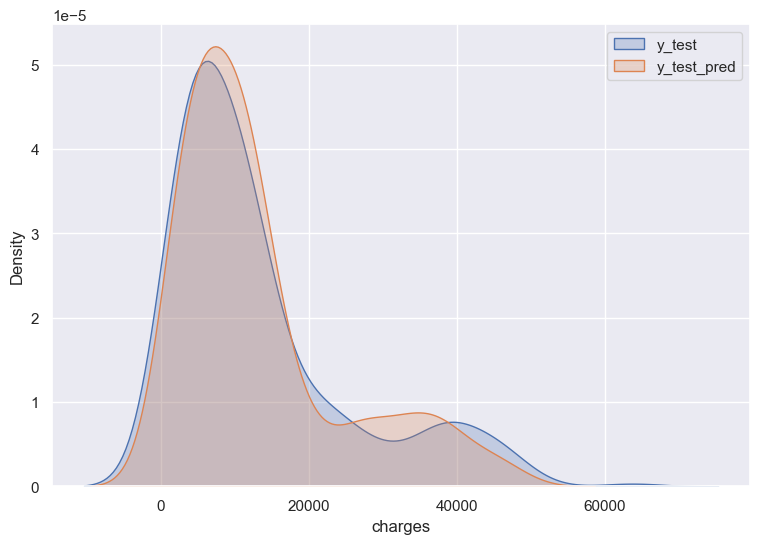

In [40]:
# Посмотрим на распределения предсказанных значений и тестовых данных.
y_pred_test = clf.predict(X_test)
sns.kdeplot(y_test, fill=True, palette=customPalette, label='y_test')
sns.kdeplot(y_pred_test, fill=True, palette=customPalette, label='y_test_pred')
plt.legend();

Важные признаки, которые влияют на результат модели, можно находить множеством способов, самые простой это использование атрибута feature_importance_, который доступен после обучения модели.

Мы с вами будем использовать метод permutation_importance() из библиотеки scikit-learn, он позволяет анализировать не только числовые, но и категориальные данные. На вход нужно подать обученную модель, данные (признаки и целевую переменную), количество повторений и метрику.

Метод Permutation Importance основан на перестановках значений в признаках: если при случайной перестановке в признаке значений это никак не влияет на значение целевой переменной, то этот признак не является важным, и наоборот. 

# [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

In [55]:
# после того как модель обучена найдем самые важные признаки
from sklearn.inspection import permutation_importance

results = permutation_importance(clf,
                                 X_test,
                                 y_test,
                                 n_repeats=30,
                                 random_state=RANDOM_STATE,
                                 scoring='neg_mean_squared_error')

perm_df = pd.DataFrame({'col': X.columns, 'value': results.importances_mean})
perm_df = round(perm_df.sort_values(by='value', ascending=False), 1)
perm_df

,col,value
3,smoker,204581188.3
0,age,29512179.8
1,bmi,23207900.8
2,children,5712797.6
6,region_northeast,-351292.2
9,region_southwest,-604626.0
8,region_southeast,-736169.4
7,region_northwest,-1273254.3
4,sex_female,-1991600.5
5,sex_male,-1991600.5


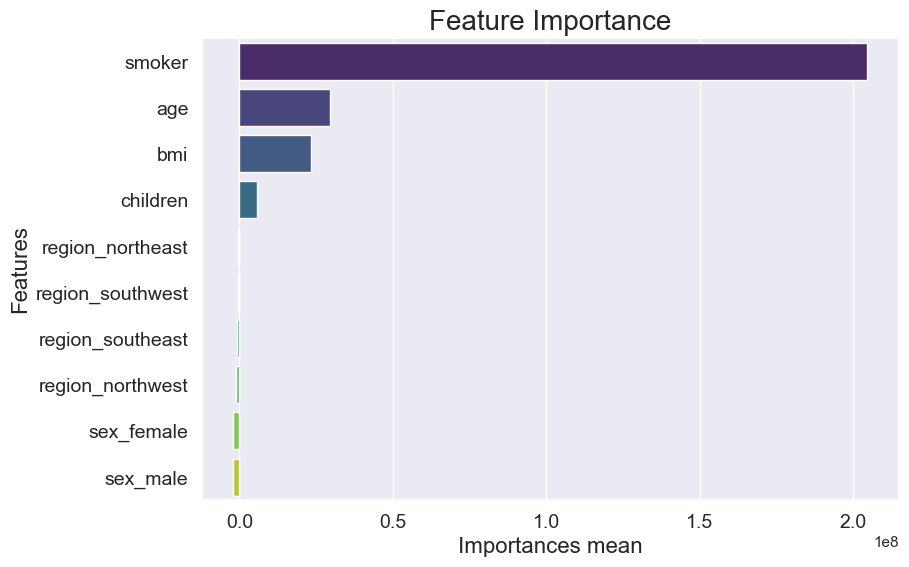

In [56]:
# изобразим графически все важные признаки
b = sns.barplot(data=perm_df, y='col', x='value', palette='viridis')
b.set_xlabel('Importances mean', fontsize=16)
b.set_ylabel('Features', fontsize=16)
b.set_title('Feature Importance', fontsize=20)
b.tick_params(labelsize=14);

# [seaborn.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html)